#Importing essential Libraries

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler

#Loading Data

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
from matplotlib import image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import imageio

image_path = '/content/drive/MyDrive/DL/Datasets/train'

image_data = []
image_masks = []

#Loading images
print("Loading Training Images...")

filenames = [os.path.join(image_path, img) for img in os.listdir(image_path)]
filenames.sort()
for img in filenames:
  image_arr = cv2.imread(img)  #One image of dim (W, H, 3)

  #Resizing
  new_image = cv2.resize(image_arr, (240,240))  
  new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB) 
  image_data.append(new_image)
  
images = np.array(image_data)


#Loading Masks
image_mask_path = '/content/drive/MyDrive/DL/Datasets/train_masks'
print("Loading Training Masks...")
filenames = [os.path.join(image_mask_path, img) for img in os.listdir(image_mask_path)]
filenames.sort()

for img in filenames:
  image_arr = imageio.imread(img)  #One image of dim (W, H, 3)
  
  #Resizing
  new_image = cv2.resize(image_arr, (240,240))  
  image_masks.append(new_image)
    
  
images = np.array(image_data)
masks = np.array(image_masks)

print("Training images shape: " ,images.shape)     
print("Training Masks shape: ",masks.shape)      #Labels are grayscale Images

Loading Training Images...
Loading Training Masks...
Training images shape:  (5088, 240, 240, 3)
Training Masks shape:  (5088, 240, 240)


Visualizing some images:

Image


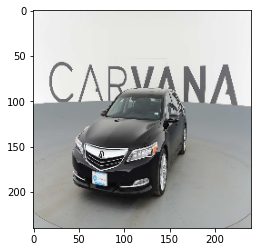

It's Mask


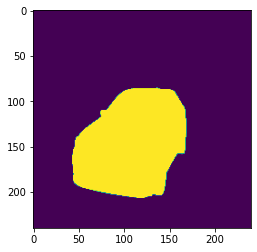

In [5]:
plt.figure(1)
print("Image")
plt.imshow(images[1])
plt.show()
plt.figure(2)
print("It's Mask")
plt.imshow(masks[1])
plt.show()

Checking if GPU is available

In [6]:
#Converting the images into tensor
if torch.cuda.is_available():
  print("cuda GPU is available")
  DEVICE = 'cuda'
else:
  print("GPU is not available")
  DEVICE = 'cpu'

cuda GPU is available


Transferring the Images to GPU

In [7]:
images = torch.tensor(images, device = DEVICE)
masks = torch.tensor(masks, device = DEVICE)

Normalize the image

In [8]:
images = images.float()
mean = (torch.mean(images))
images = images/ mean

Reshaping the Image for network to work on

In [9]:
#changing image dimension to that which is accepted by the the model
images = images.permute(0,3,1,2)

#Creating Unet Netowk architecture

##Paper: https://arxiv.org/abs/1505.04597
There is some changes as compared to orignal Unet architectures to improve the performance

In [10]:
class unet(nn.Module):

  def __init__(self, in_channels, out_channels, features):     #Features is the dimension of Height and Width of the image
    super(unet, self).__init__()
    self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv5 = nn.Sequential(
            nn.Conv2d(512, 1024, 3, 1, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, 3, 1, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
        )

    #upsampling layers
    self.up1 = nn.ConvTranspose2d( 1024, 512, kernel_size=2, stride=2, )
    self.conv6 = nn.Sequential(
            nn.Conv2d(1024, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
    
    self.up2 = nn.ConvTranspose2d( 512, 256, kernel_size=2, stride=2, )
    self.conv7 = nn.Sequential(
            nn.Conv2d(512, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
    
    self.up3 = nn.ConvTranspose2d( 256, 128, kernel_size=2, stride=2, )
    self.conv8 = nn.Sequential(
            nn.Conv2d(256, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
    
    self.up4 = nn.ConvTranspose2d( 128, 64, kernel_size=2, stride=2, )
    self.conv9 = nn.Sequential(
            nn.Conv2d(128, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
    self.conv_final = nn.Conv2d(64, out_channels, 3, 1, 1)               #output channel is the no of classes
    
  def forward(self, input):

    #Downsampling Part
    out = self.conv1(input)
    out_1 = out
    out = self.pool1(out)       #()

    out = self.conv2(out)
    out_2 = out
    out = self.pool2(out)

    out = self.conv3(out)
    out_3 = out
    out = self.pool3(out)
    
    out = self.conv4(out)
    out_4 = out
    out = self.pool4(out)
    
    out = self.conv5(out)
    
    #Upsampling part
    out = self.up1(out)    
    out = torch.cat((out_4, out), dim = 1)
    out = self.conv6(out)

    out = self.up2(out)     
    out = torch.cat((out_3, out), dim = 1)
    out = self.conv7(out)

    out = self.up3(out)     
    out = torch.cat((out_2, out), dim = 1)
    out = self.conv8(out)

    out = self.up4(out)     
    out = torch.cat((out_1, out), dim = 1)
    out = self.conv9(out)

    out = self.conv_final(out)

    return out

    #Using transpose convolutions insted of Bilinear interpolation used in orignal paper




In [11]:
model = unet(3, 1, 280).to(device = DEVICE)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#loss_type = torch.nn.CrossEntropyLoss()
loss_type = nn.L1Loss()
step_lr = lr_scheduler.StepLR(optimizer, step_size= 50, gamma = 0.8)   #Every 10 epochs our learning rate will be multiplied by gamma

In [13]:
#Model Training
loss_graph = []
num_epochs = 1000
num_train = images.shape[0]
batch_size = 15
for i in range(num_epochs):
  random_no = torch.randint(0, num_train, (batch_size,))
  x_batch = images[random_no]
  y_batch = masks[random_no]

  model.train()
  optimizer.zero_grad()
  y_pred = model(x_batch)
  y_pred = y_pred.reshape(15,240,240).float()
  loss = loss_type(y_pred, y_batch)
  loss.backward()
  optimizer.step()
  loss_graph.append(loss.cpu().item())
  if i%10==0:
    print("Epoch: ", i, ", loss is: ", loss.cpu().item())

Epoch:  0 , loss is:  63.543212890625
Epoch:  10 , loss is:  48.57160949707031
Epoch:  20 , loss is:  48.70029067993164
Epoch:  30 , loss is:  45.91012954711914
Epoch:  40 , loss is:  43.7640266418457
Epoch:  50 , loss is:  43.914573669433594
Epoch:  60 , loss is:  44.82711410522461
Epoch:  70 , loss is:  43.04243087768555
Epoch:  80 , loss is:  37.817222595214844
Epoch:  90 , loss is:  38.91039276123047
Epoch:  100 , loss is:  41.0832633972168
Epoch:  110 , loss is:  37.24325942993164
Epoch:  120 , loss is:  24.67530059814453
Epoch:  130 , loss is:  27.82929039001465
Epoch:  140 , loss is:  26.423856735229492
Epoch:  150 , loss is:  22.988378524780273
Epoch:  160 , loss is:  19.141979217529297
Epoch:  170 , loss is:  20.210689544677734
Epoch:  180 , loss is:  12.575911521911621
Epoch:  190 , loss is:  4.718294620513916
Epoch:  200 , loss is:  4.683204650878906
Epoch:  210 , loss is:  3.7182400226593018
Epoch:  220 , loss is:  4.065667629241943
Epoch:  230 , loss is:  5.339708805084228

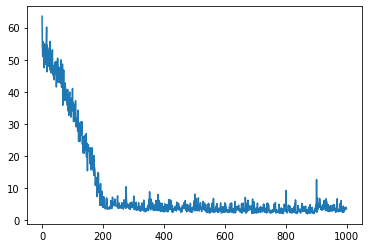

In [14]:
#Loss Graph
plt.plot(loss_graph)

#Final result from the Trained Model: 

torch.Size([1, 1, 240, 240])
Predicted segmentation mask


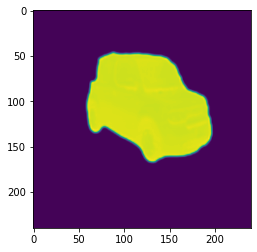

Actual mask


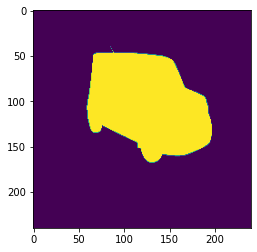

In [15]:
y = model(images[30].reshape(1,images.shape[1], images.shape[2], images.shape[3]))
print(y.shape)
plt.figure(3)
print("Predicted segmentation mask")
plt.imshow(np.array(y.reshape(240,240).detach().cpu().numpy()))
plt.show()

plt.figure(4)
print("Actual mask")
plt.imshow(np.array(masks[30].clone().cpu()))
plt.show()

#Saving the weights of the trined Model:


In [16]:
save_model = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
path_save = '\content\drive\MyDrive\DL\model_unet.pth.tar'
torch.save(save_model, path_save)
print("Model Saved ")

Model Saved 


#Loading the trained model and using it to detect masks

In [17]:
load_path = '/content/drive/MyDrive/DL/model_unet.pth.tar'
load = torch.load(load_path)
model_load = unet(3, 1, 280).to(device = DEVICE)
model_load.load_state_dict(load['state_dict'])

<All keys matched successfully>

Predicted segmentation mask


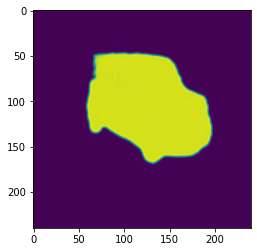

Actual mask


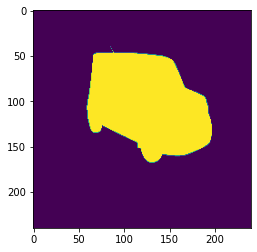

In [18]:
y = model_load(images[30].reshape(1,images.shape[1], images.shape[2], images.shape[3]))
plt.figure(3)
print("Predicted segmentation mask")
plt.imshow(np.array(y.reshape(240,240).detach().cpu().numpy()))
plt.show()

plt.figure(4)
print("Actual mask")
plt.imshow(np.array(masks[30].clone().cpu()))
plt.show()